In [72]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings('ignore')

# **Load data**

In [73]:
data = pd.read_csv('/kaggle/input/spotifydataset/spotifyDataset.csv', index_col = 0)

## Значения колонок

- track_id - id трека
- artists - имя артиста
- album_name - имя альбома
- track_name - имя трека
- popularity - популярность 
- duration_ms - длительность в милисек
- explicit - наличие плохих слов
- danceability - танцевальность
- energy - энергичность
- key - тональность
- loudness - громкость
- mode - 
- speechiness - наличия слов в песне
- acousticness - акустичность
- instrumentalness - инструментальность
- liveness - живое исполнение
- valence - позитивность
- tempo - темп
- time_signature - размерность
- track_genre - жанр

#### Целевая переменная - `popularity`  
Установим постоянную случайность, чтобы можно было сравнивать результаты моделей

In [74]:
TARGET = 'popularity'
SEED = 42

Загрузим данные и выведем случайные 5 строк из набора

In [75]:
data.sample(5)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
49351,5u6MUAawmhnFHVGaAGDj2v,Brennan Heart;Jake Reese,Lose It All,Lose It All,51,208000,False,0.362,0.7520,0,-4.449,0,0.0384,0.161,0.000000,0.135,0.282,149.548,4,hardstyle
67456,0WRYlYYbEFVg0ZutdOpHyQ,Luis Fonsi;Manuel Turizo,Verano en Junio,Vacaciones,0,155440,False,0.711,0.7480,7,-4.044,1,0.0831,0.130,0.000000,0.546,0.844,167.972,4,latin
16071,7whMmWEv7MovcqvrKDQyBZ,Frédéric Chopin;Daniel Barenboim,Clásica para los niños de hoy,"Berceuse in D flat, Op. 57",0,288360,False,0.297,0.0565,1,-37.107,1,0.0493,0.977,0.936000,0.727,0.175,126.006,4,classical
64065,3siiSoWFWuwTOERUPAAvCY,Norah Jones,JULPYNTA,December,0,185680,False,0.414,0.1310,4,-12.817,1,0.0347,0.934,0.000079,0.110,0.112,143.778,4,jazz
18264,2233kDpGzceCjohT46Y4PX,Glenn Wool,Let Your Hands Go,Why You Shouldn't Do Topical Material on Albums,23,108184,True,0.556,0.8310,7,-6.184,1,0.7590,0.881,0.000000,0.694,0.550,82.004,4,comedy


Посмотрим на размеры данных

In [76]:
print(f'Размер набора данных: {data.shape}')

Размер набора данных: (114000, 20)


# **Exploratory Data Analysis**

Проверим, есть ли nan-значения в данных

track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


<Axes: >

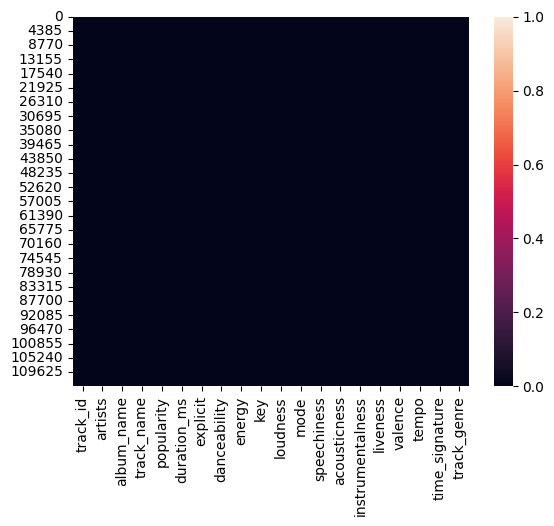

In [77]:
data_nans = data.isnull()
print(data_nans.sum())
sns.heatmap(data_nans)

Видим, что есть 3 признака, которые имеют по одному пропущенному значению, удалим эти строчки.

In [78]:
data = data.dropna(axis=0)

print(data.isnull().sum())

track_id            0
artists             0
album_name          0
track_name          0
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64


In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113999 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_id          113999 non-null  object 
 1   artists           113999 non-null  object 
 2   album_name        113999 non-null  object 
 3   track_name        113999 non-null  object 
 4   popularity        113999 non-null  int64  
 5   duration_ms       113999 non-null  int64  
 6   explicit          113999 non-null  bool   
 7   danceability      113999 non-null  float64
 8   energy            113999 non-null  float64
 9   key               113999 non-null  int64  
 10  loudness          113999 non-null  float64
 11  mode              113999 non-null  int64  
 12  speechiness       113999 non-null  float64
 13  acousticness      113999 non-null  float64
 14  instrumentalness  113999 non-null  float64
 15  liveness          113999 non-null  float64
 16  valence           113999 

Удалим `track_id`, так как важной информации этот признак не несет

In [80]:
data.drop(columns=['track_id'], axis=1, inplace=True)

Разделим признаки на количественные и качественные

In [81]:
numerical_features = data.select_dtypes(include=['number']).columns.tolist()
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
bool_features = data.select_dtypes(include=['bool']).columns.tolist()

Посмотрим на качественные признаки

In [82]:
print(categorical_features)
print(data['track_genre'].unique())
print(data['track_genre'].nunique())

['artists', 'album_name', 'track_name', 'track_genre']
['acoustic' 'afrobeat' 'alt-rock' 'alternative' 'ambient' 'anime'
 'black-metal' 'bluegrass' 'blues' 'brazil' 'breakbeat' 'british'
 'cantopop' 'chicago-house' 'children' 'chill' 'classical' 'club' 'comedy'
 'country' 'dance' 'dancehall' 'death-metal' 'deep-house' 'detroit-techno'
 'disco' 'disney' 'drum-and-bass' 'dub' 'dubstep' 'edm' 'electro'
 'electronic' 'emo' 'folk' 'forro' 'french' 'funk' 'garage' 'german'
 'gospel' 'goth' 'grindcore' 'groove' 'grunge' 'guitar' 'happy'
 'hard-rock' 'hardcore' 'hardstyle' 'heavy-metal' 'hip-hop' 'honky-tonk'
 'house' 'idm' 'indian' 'indie-pop' 'indie' 'industrial' 'iranian'
 'j-dance' 'j-idol' 'j-pop' 'j-rock' 'jazz' 'k-pop' 'kids' 'latin'
 'latino' 'malay' 'mandopop' 'metal' 'metalcore' 'minimal-techno' 'mpb'
 'new-age' 'opera' 'pagode' 'party' 'piano' 'pop-film' 'pop' 'power-pop'
 'progressive-house' 'psych-rock' 'punk-rock' 'punk' 'r-n-b' 'reggae'
 'reggaeton' 'rock-n-roll' 'rock' 'rockabi

У нас есть `track_genre`, проведем небольшой feauture engineering, преобразуем этот признак в числовый.  

У нас 114 классов условно, посчитаем для каждого класса его частотную составляющую.

In [ ]:
# track_genre_classes = data['track_genre'].unique()
# track_genre_counts = data['track_genre'].value_counts()
# track_genre_freq = {genre: freq/track_genre_counts.sum() for genre, freq in zip(track_genre_classes, track_genre_counts)}

In [83]:
len(data['track_genre'].value_counts()[data['track_genre'].value_counts() == 1000])

113

Так количество треков по каждому жанру равно 1000 -> значения этого признака для каждой точки данных одинаково -> признак можно удалить. Остальные качественные признаки содержат информацию о альбоме, исполнители и название трека, что является текстовой информацией. Попробуем поработать только с числовыми признаками.

In [84]:
categorical_features.remove('track_genre')
categorical_features

['artists', 'album_name', 'track_name']

Преобразуем булевые признаки в целочисленные

In [85]:
data[bool_features] = data[bool_features].astype(np.int64)
numerical_features = data.select_dtypes(include=['number']).columns.tolist()

In [86]:
data[numerical_features].describe()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,113999.000000,1.139990e+05,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000,113999.000000
mean,33.238827,2.280312e+05,0.085501,0.566801,0.641383,5.309126,-8.258950,0.637558,0.084652,0.314907,0.156051,0.213554,0.474066,122.147695,3.904034
std,22.304959,1.072961e+05,0.279627,0.173543,0.251530,3.559999,5.029357,0.480708,0.105733,0.332522,0.309556,0.190378,0.259261,29.978290,0.432623
min,0.000000,8.586000e+03,0.000000,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,1.740660e+05,0.000000,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218500,4.000000
50%,35.000000,2.129060e+05,0.000000,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,50.000000,2.615060e+05,0.000000,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.597500,0.049000,0.273000,0.683000,140.071000,4.000000
max,100.000000,5.237295e+06,1.000000,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


Можно заметить, что стандартное отклонения у большинства признаков меньше единицы.  
Построим распределения и посмотрим на них.

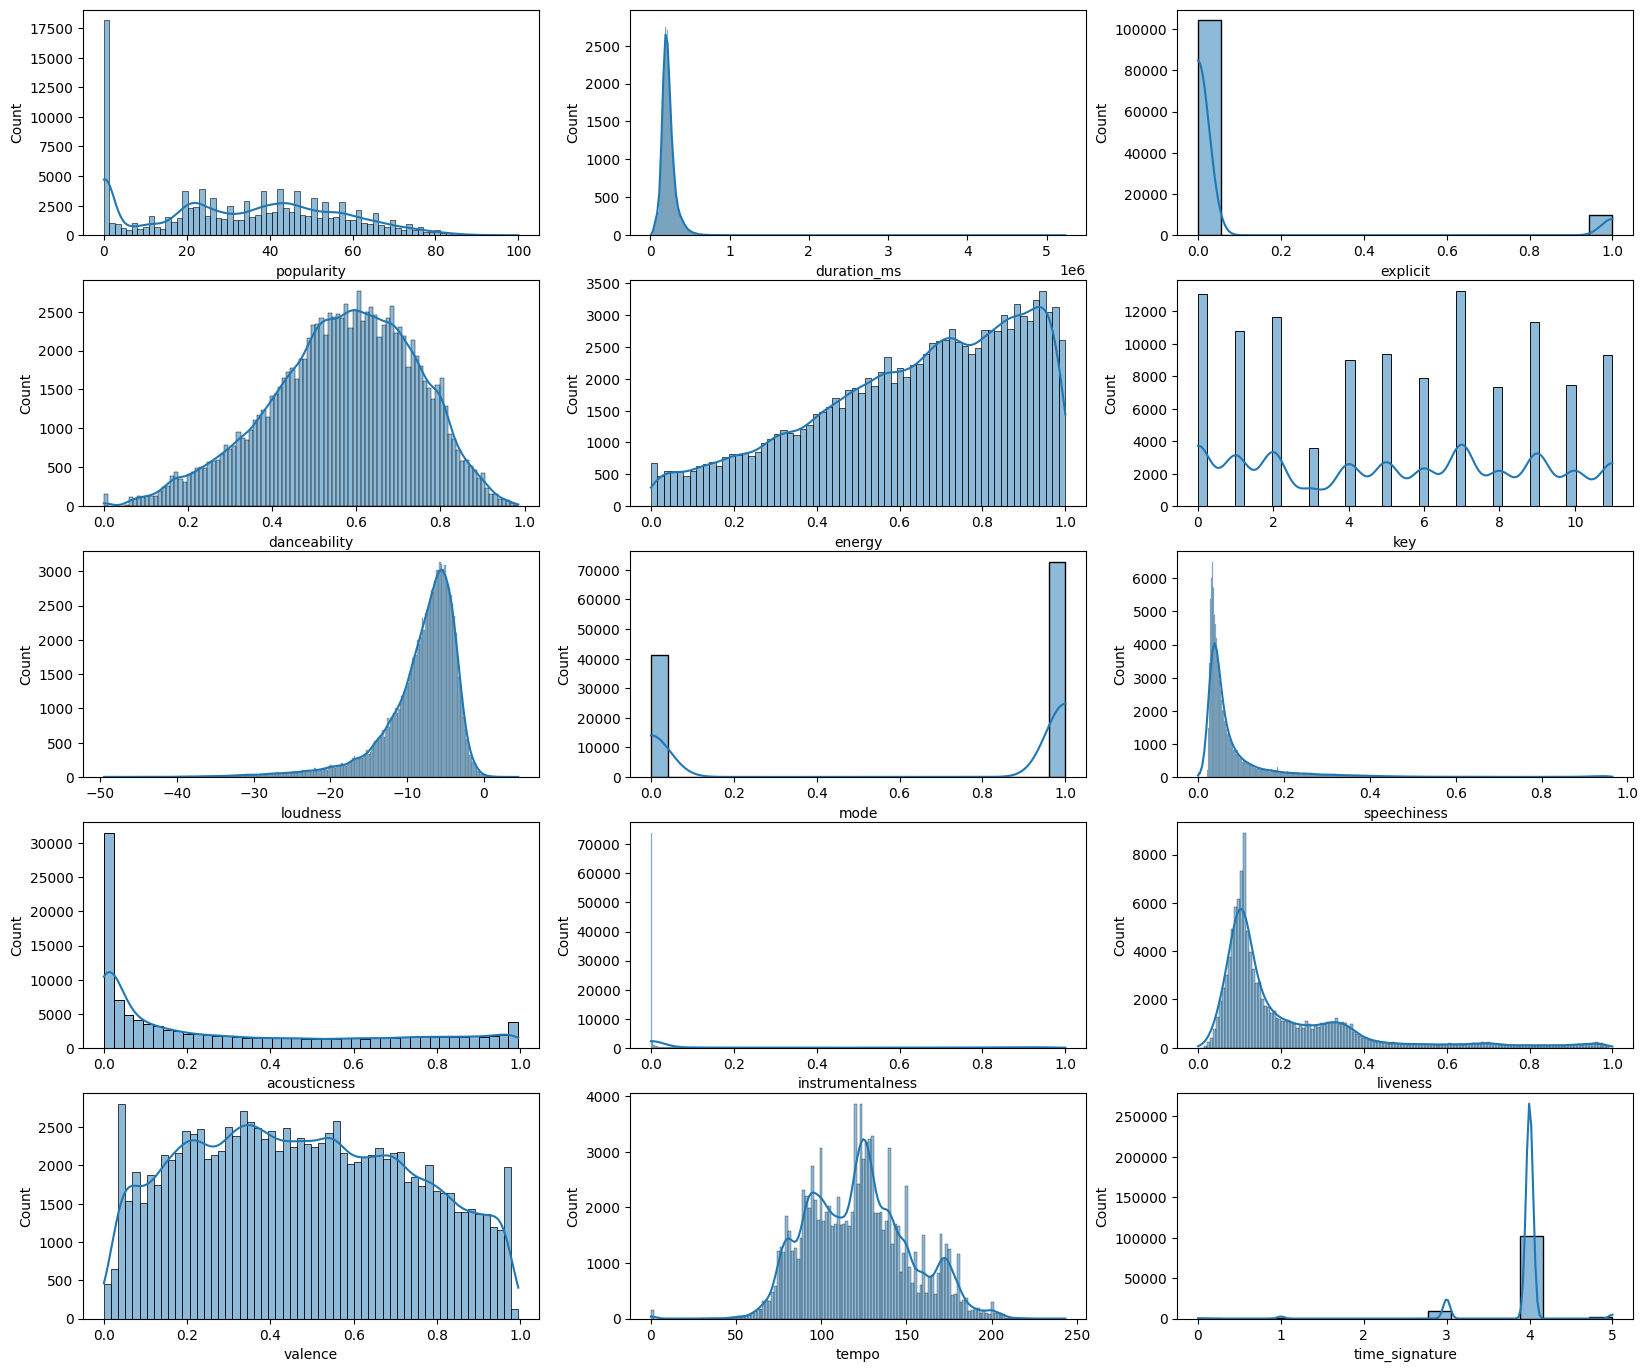

In [87]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,17))

for ax ,col in zip(axes.ravel(), numerical_features):
    sns.histplot(data[col], ax=ax, kde=True)

Если внимательно посмотреть, то можно увидеть среди них есть категориальные признаки, но уже в готовом числовом формате:
- `mode`
- `explicit`

Итак:
- `instrumentalness` - признак будет удален, так как он ужасно не сбаласнирован, такое рапсределение выправить очень трудно и есть ли в этом смысл?
- `time_signature` - в признаке преобладают буквально два значения 3 и 4, количество остальных очень мало
- `explicit` - признак не очень сбалансирован, так как песень с плохими словами гораздо меньше чем без них
- `valence` - признак распределен не равномерно, но стремится к этому
- `danceability` - близится к нормальному распределению
- `tempo` - имеет небольшие выбросы с обеих сторон, а в целом неплохо
- `acousticness` - большая часть распределена равномерно, хотя нулевые значения преобладают
- `energy` - напоминает возрастающий тренд, в целом что логично и энергичность так и должна быть
- `liveness, speechiness` - имеет выбросы в виде длинного правого хвоста
- `loudness` - имеет выбросы в виде длинного левого хвоста
- `mode` - распределен неплохо в соотношение классов
- `key` - все хорошо
- `duration_ms` - имеет сильные выбросы, так как среднее время записи песень близко друг другу
- `popularity TARGET` - распределен неплохо, но преобладание нулевых значений оказывает значительное влияние  
  
Думаю тут хорошо будет справляться нейронка, учитывая качество наших данных, она сможет уловить более сложные взаимосвязи между признаками.

Удалим `instrumentalness`

In [88]:
data.drop(columns=['instrumentalness'],axis=1,inplace=True)
numerical_features.remove('instrumentalness')

Проведем корреляционный анализ признаков

<Axes: title={'center': 'Таблица корреляции количественных признаков'}>

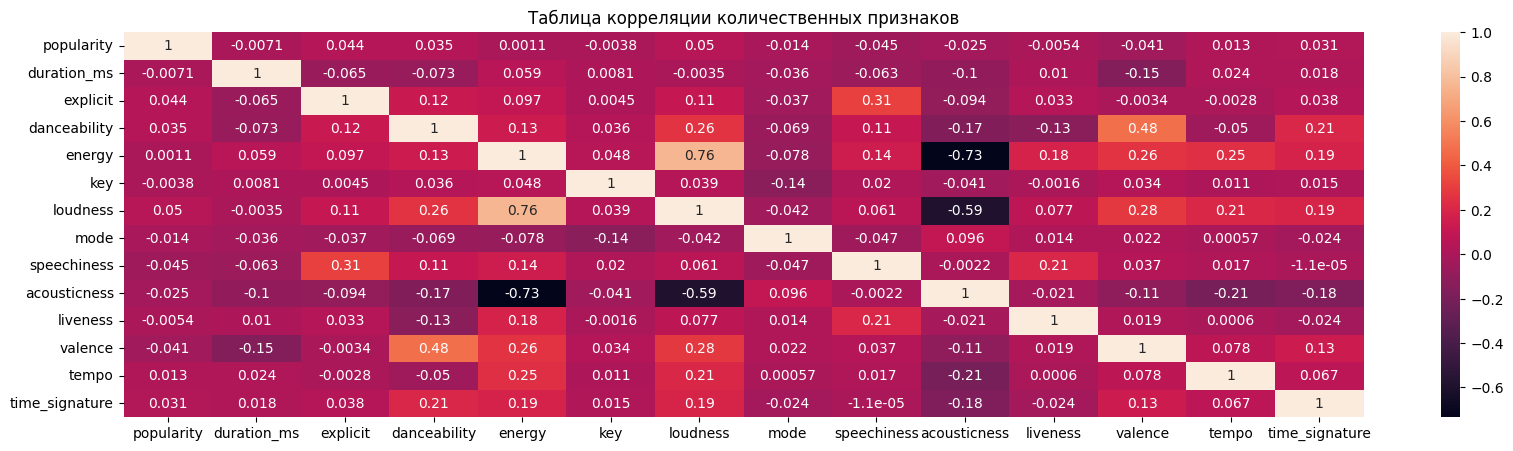

In [89]:
plt.figure(figsize=(20, 5))
plt.title('Таблица корреляции количественных признаков')
sns.heatmap(data[numerical_features].corr(), annot=True)

Мультиколлинеарность есть, но слабая, то есть признаки слабо коррелированны между собой.  
Если мы посмотрим на первый столбец `popularity`, которые является таргетом, то заметим, что признаки практически не имеют с ним линейной связи -> связь более сложная и нелинейная.

Посмотрим на распределение ранга популярности 

popularity
0      16019
22      2354
21      2344
44      2288
1       2140
       ...  
96         7
94         7
95         5
100        2
99         1
Name: count, Length: 101, dtype: int64


<BarContainer object of 101 artists>

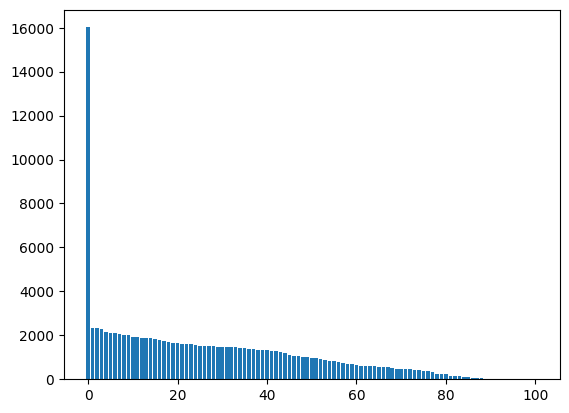

In [90]:
print(data['popularity'].value_counts())
plt.bar(np.arange(0,101),data['popularity'].value_counts())

## **Feature Engineering**

Создадим новые признаки (может быть не самые лучшие варианты, но нашел цель попрактиковаться в этом):
- `energy * loudness`
- `danceability * tempo`
- `log(duration_ms + 1)` - чтобы уменьшить влияние выбросов
- `log(speechiness + 1)` - чтобы уменьшить влияние выбросов
- `log(liveness + 1)` - чтобы уменьшить влияние выбросов

In [91]:
data = data[numerical_features].copy()

In [92]:
data['energy_loudness'] = data['energy'] * data['loudness']
data['danceability_tempo'] = data['danceability'] * data['loudness']
data['log_duration_ms'] = np.log(data['duration_ms'] + 1)
data['log_speechiness'] = np.log(data['speechiness'] + 1)
data['log_liveness'] = np.log(data['liveness'] + 1)

In [93]:
data

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,liveness,valence,tempo,time_signature,energy_loudness,danceability_tempo,log_duration_ms,log_speechiness,log_liveness
0,73,230666,0,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.3580,0.7150,87.917,4,-3.109906,-4.560296,12.348730,0.133656,0.306013
1,55,149610,0,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.1010,0.2670,77.489,4,-2.861010,-7.238700,11.915794,0.073529,0.096219
2,57,210826,0,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.1170,0.1200,76.332,4,-3.494506,-4.263492,12.258793,0.054204,0.110647
3,71,201933,0,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.1320,0.1430,181.740,3,-1.103494,-4.924990,12.215696,0.035657,0.123986
4,82,198853,0,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.0829,0.1670,119.949,4,-4.288683,-5.982858,12.200326,0.051263,0.079643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113995,21,384999,0,0.172,0.2350,5,-16.393,1,0.0422,0.6400,0.0863,0.0339,125.995,5,-3.852355,-2.819596,12.860999,0.041334,0.082777
113996,22,385000,0,0.174,0.1170,0,-18.318,0,0.0401,0.9940,0.1050,0.0350,85.239,4,-2.143206,-3.187332,12.861001,0.039317,0.099845
113997,22,271466,0,0.629,0.3290,0,-10.895,0,0.0420,0.8670,0.0839,0.7430,132.378,4,-3.584455,-6.852955,12.511596,0.041142,0.080566
113998,41,283893,0,0.587,0.5060,7,-10.889,1,0.0297,0.3810,0.2700,0.4130,135.960,4,-5.509834,-6.391843,12.556356,0.029267,0.239017


Разделим наши данные на train и test, делаем это до стандартизации, чтобы не произошла утечка данных в тестовый набор.

In [94]:
X = data.drop(columns=[TARGET],axis=1)
y = data['popularity']

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

Проведем стандартизацию

In [96]:
scaler = StandardScaler()

X_train_scaled= scaler.fit_transform(X_train)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

## **Отбор признаков**

Сделаем отбор признаков с помощью SelectFromModel

In [97]:
tree_model = RandomForestRegressor(n_estimators=100, max_depth=7)

sel = SelectFromModel(tree_model, threshold='median', max_features=18)

sel.fit(X_train_scaled, y_train)

selected_train = sel.transform(X_train_scaled)
selected_train = pd.DataFrame(selected_train,columns=sel.get_feature_names_out())

selected_test = sel.transform(X_test_scaled)
selected_test = pd.DataFrame(selected_test,columns=sel.get_feature_names_out())

Теперь посмотрим какие признаки выбрала модель и какова их важность

<Axes: xlabel='Importance', ylabel='Feature'>

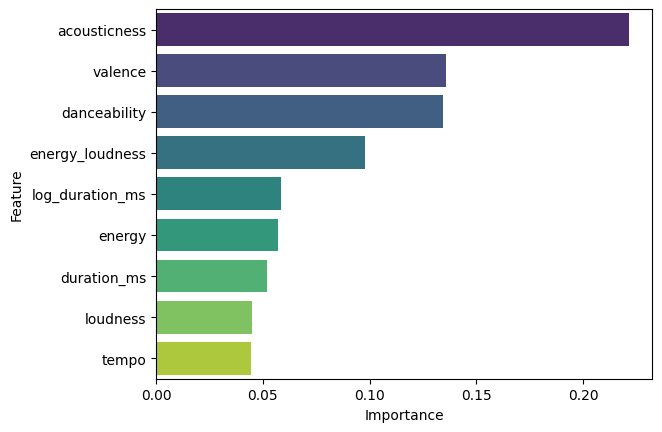

In [98]:
feature_importance_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': sel.estimator_.feature_importances_
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

selected_features = sel.get_feature_names_out()
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.loc[feature_importance_df['Feature'].isin(selected_features)], palette='viridis')

Модель посчитала наиболее важный признак - акустичность, далее позитивность, далее насколько под него тянет танцевать. Тут на самом деле трудно поспорить, потому что это действительно так. Это топ 3 признаков. Также можешь заметить, что есть два сгенерированных нами признака `energy_loudness` и `log_duration_ms`. Но есть и просто `duration_ms`, я считаю его можно удалить. Так как ниже увидим, что между ними сильная корреляция.

<Axes: title={'center': 'Таблица корреляции'}>

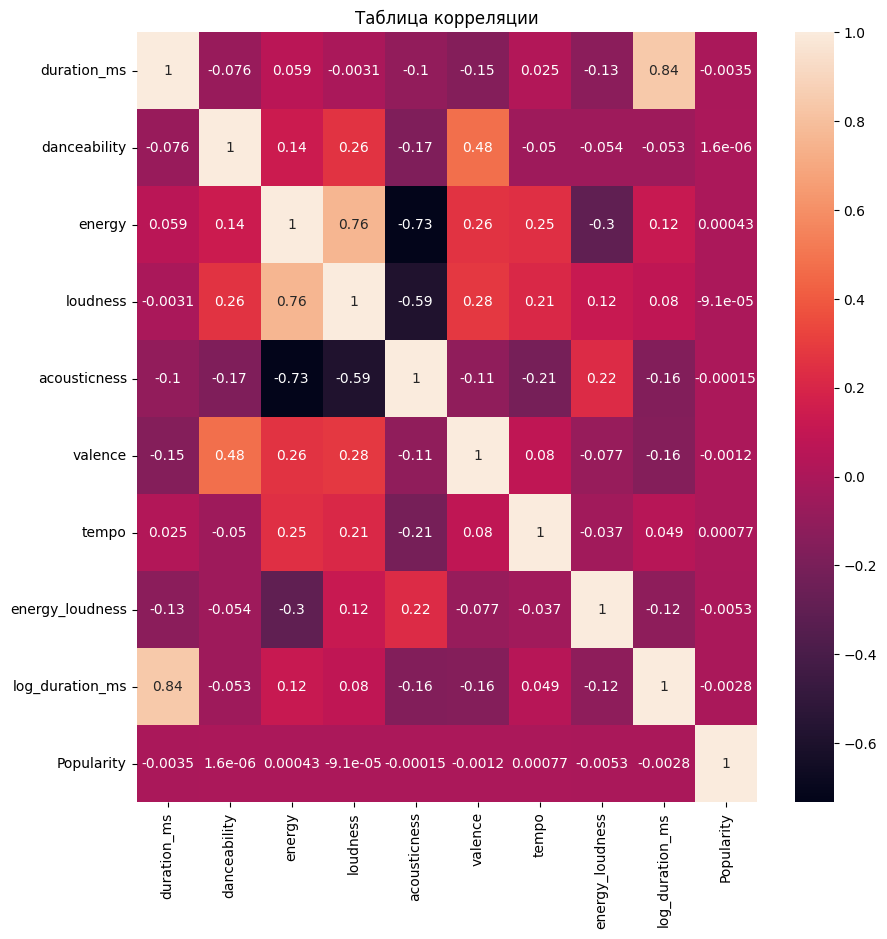

In [99]:
selected_X_corr = selected_train.copy()
selected_X_corr['Popularity'] = y

plt.figure(figsize=(10, 10))
plt.title('Таблица корреляции')
sns.heatmap(selected_X_corr.corr(), annot=True)

Удалим `duration_ms` и у нас останется 8 наиболее значимых признака. Мультиколлинеарность слабая.

In [100]:
selected_train.drop('duration_ms', axis=1, inplace=True)
selected_test.drop('duration_ms', axis=1, inplace=True)

# **Модели**

Чтобы подобрать оптимальные гиперпараметры для моделей, будем использовать класс GridSearch (перебирает все варианты).  
В качестве моделей возьмем по одной штуки из каждого семейства, а такде напишем свою нейронку на tensorflow/keras.

Определим тип кросс-валидации и зададим ему параметры

In [101]:
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

## **Linear Regression**

In [102]:
lin_model = LinearRegression()

scores = cross_val_score(lin_model, selected_train, y_train, cv=kf, scoring='neg_mean_squared_error')

lin_model.fit(selected_train, y_train)

LinearRegression()

In [103]:
print(f'Среднее RMSE на кросс-валидации: {(-scores).mean()**0.5}')
print(f'RMSE на тестовых данных: {mean_squared_error(y_test, lin_model.predict(selected_test))**0.5}')

Среднее RMSE на кросс-валидации: 22.18266456291038
RMSE на тестовых данных: 22.161272039365034


## **Decision Tree**

In [104]:
params = {
    'random_state': [SEED],
    'max_depth': [17],
    'min_samples_split': [2],
    'min_samples_leaf': [6]
}

dec_tree_model = DecisionTreeRegressor()

search = GridSearchCV(dec_tree_model, param_grid=params, n_jobs=-1, cv=kf, scoring='neg_mean_squared_error')

search.fit(selected_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [17], 'min_samples_leaf': [6],
                         'min_samples_split': [2], 'random_state': [42]},
             scoring='neg_mean_squared_error')

In [105]:
best_estimator = search.best_estimator_

print(f'Среднее RMSE на кросс-валидации: {(-search.cv_results_["mean_test_score"][0])**0.5}')
print(f'RMSE на тестовых данных: {mean_squared_error(y_test, best_estimator.predict(selected_test))**0.5}')

Среднее RMSE на кросс-валидации: 20.881821566741024
RMSE на тестовых данных: 20.577677073078398


## **RandomForest**

In [106]:
params = {
    'random_state': [SEED],
    'max_depth': [5],
    'min_samples_split': [2],
    'min_samples_leaf': [3],
    'n_estimators': [40]
}


rf_rg_model = RandomForestRegressor()

search = GridSearchCV(rf_rg_model, param_grid=params, n_jobs=-1, cv=kf, scoring='neg_mean_squared_error')

search.fit(selected_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [5], 'min_samples_leaf': [3],
                         'min_samples_split': [2], 'n_estimators': [40],
                         'random_state': [42]},
             scoring='neg_mean_squared_error')

In [107]:
best_estimator = search.best_estimator_

print(f'Среднее RMSE на кросс-валидации: {(-search.cv_results_["mean_test_score"][0])**0.5}')
print(f'RMSE на тестовых данных: {mean_squared_error(y_test, best_estimator.predict(selected_test))**0.5}')

Среднее RMSE на кросс-валидации: 21.732071514771565
RMSE на тестовых данных: 21.704571620710734


## **GradientBoosting**

In [108]:
params = {
    'random_state': [SEED],
    'max_depth': [3],
    'min_samples_split': [15],
    'min_samples_leaf': [3],
    'n_estimators':[150]
}

grad_model = GradientBoostingRegressor()

search = GridSearchCV(grad_model, param_grid=params, n_jobs=-1, cv=kf, scoring='neg_mean_squared_error')

search.fit(selected_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3], 'min_samples_leaf': [3],
                         'min_samples_split': [15], 'n_estimators': [150],
                         'random_state': [42]},
             scoring='neg_mean_squared_error')

In [109]:
best_estimator = search.best_estimator_

print(f'Среднее RMSE на кросс-валидации: {(-search.cv_results_["mean_test_score"][0])**0.5}')
print(f'RMSE на тестовых данных: {mean_squared_error(y_test, best_estimator.predict(selected_test))**0.5}')

Среднее RMSE на кросс-валидации: 21.26756008990608
RMSE на тестовых данных: 21.24031476450601


Text(0.5, 1.0, 'График лосса')

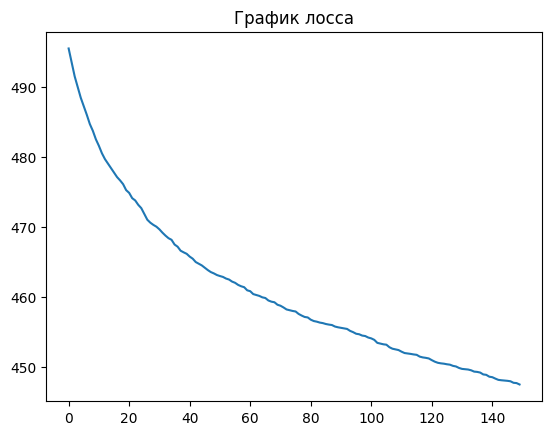

In [110]:
plt.plot(best_estimator.train_score_)
plt.title('График лосса')

## **Model on tensorflow/keras**

In [111]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [112]:
input_shape = (selected_train.shape[1],) 

In [117]:
def create_model(input_shape):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.7))
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='mse',
                  metrics=['mse'])
    return model


val_losses = []
val_mses = []

selected_train_np = selected_train.to_numpy()
y_train_np = y_train.to_numpy()
folds_counter = 1

for train_index, val_index in kf.split(selected_train_np):
    print(f'Фолд {folds_counter}')
    X_train_fold, X_val_fold = selected_train_np[train_index], selected_train_np[val_index]
    y_train_fold, y_val_fold = y_train_np[train_index], y_train_np[val_index]

    model = create_model(input_shape)

    history = model.fit(
        X_train_fold, y_train_fold,
        epochs=20,
        batch_size=64,
        validation_data=(X_val_fold, y_val_fold),
        verbose=1
    )

    mse = history.history['val_mse'][-1]
    val_losses.append(history.history['val_loss'][-1])
    val_mses.append(mse)
    print(f'Значение MSE на кросс-валидации: {mse**0.5}')
    folds_counter += 1


Фолд 1
Epoch 1/20
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 734.1071 - mse: 734.1071 - val_loss: 487.1185 - val_mse: 487.1185
Epoch 2/20
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 566.8997 - mse: 566.8997 - val_loss: 471.9408 - val_mse: 471.9408
Epoch 3/20
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 557.6717 - mse: 557.6717 - val_loss: 478.5604 - val_mse: 478.5604
Epoch 4/20
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 553.6654 - mse: 553.6654 - val_loss: 472.4429 - val_mse: 472.4429
Epoch 5/20
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 543.9288 - mse: 543.9288 - val_loss: 485.0927 - val_mse: 485.0927
Epoch 6/20
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 535.4480 - mse: 535.4480 - val_loss: 475.5330 - val_mse: 475.5330
Epoch 7/20
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 536.9575 - mse: 536.9575 - val_loss: 469.2110 - val_mse: 469.2110
Epoch 8/20
1140/1140 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 527.4217 - mse: 527.4217 - val_loss

In [118]:
print(f"Среднее значение MSE на кросс-валидации: {np.mean(val_mses)**0.5}")

Среднее значение MSE на кросс-валидации: 21.403311129237036


Фолд 1   
MSE - 21.44965802967133

Фолд 2   
MSE - 21.42667179951886

Фолд 3  
MSE - 21.396800206620412

Фолд 4  
MSE - 21.39621257600644

Фолд 5  
MSE - 21.347074057134417

**Вывод:**   
Среднее значение MSE - 21.403311129237036. На мой взгляд это достаточно много. Но если учитывать, что это моя первая работа с подобной метрикой и датасетом, то нормально. Есть куда расти.

## Итоговый вывод

При выполнении проекта по предсказанию популярности треков была произведена аналитика датасета, был проведен Feature Engineering, были проанализированны новые фичи, были построены разные модели.

В целом результаты всех моделей близки по метрикам и похоже. Возможно в силу нехватки еще определенных знаний, я не могу понять что не хватает, лучше анализ провести, возможно я упускаю какие-то важные детали. Также стоит учесть, что у нас была еще текстовая информация, которая возможно могла бы улучшить метрики, но я исключительно работал с числовыми фичами, чтобы посмотреть, какого результата можно достичь, используя только их.    
Среднее значение MSE у нейронной сети получилось - 21.4033, результат не потрясающий, но, возможно если учесть замечания, которые написал выше, то метрика поменяется в лучшую сторону.